In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector #conexión con MySQL
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import pickle

## Preparación de datos

Conexión con MySQL

In [3]:
try:
    conexion = mysql.connector.connect(
        host="localhost",
        user="root",
        password="88121356320",
        database="TFM"
    )
    cursor = conexion.cursor()

    cursor.execute("SELECT * FROM DB_TFM")
    resultados = cursor.fetchall()
    columnas = [descripcion[0] for descripcion in cursor.description] # Obtener los nombres de las columnas

    DB_TFM = pd.DataFrame(resultados, columns=columnas) # Crear el DataFrame

    print(DB_TFM) # Imprimir el DataFrame

except mysql.connector.Error as error:
    print("Error al conectar a la base de datos:", error)

finally:
    if conexion and conexion.is_connected():
        cursor.close()
        conexion.close()
        print("La conexión a la base de datos está cerrada")

       ERISubgrupoDescripcion     Sociedad Ejercicio NumeroDocumento  \
0    2-1 - COSTO DE SERVICIOS  CO10 - LASA    2022.0      3600015681   
1    2-1 - COSTO DE SERVICIOS  CO10 - LASA    2022.0      3600015682   
2    2-1 - COSTO DE SERVICIOS  CO10 - LASA    2022.0      3600015683   
3    2-1 - COSTO DE SERVICIOS  CO10 - LASA    2022.0      3600015684   
4    2-1 - COSTO DE SERVICIOS  CO10 - LASA    2022.0      3600015685   
..                        ...          ...       ...             ...   
487  2-1 - COSTO DE SERVICIOS  CO10 - LASA    2022.0      1200027481   
488  2-1 - COSTO DE SERVICIOS  CO10 - LASA    2022.0      1200027481   
489  2-1 - COSTO DE SERVICIOS  CO10 - LASA    2022.0      1200027481   
490  2-1 - COSTO DE SERVICIOS  CO10 - LASA    2022.0      1200027481   
491  2-1 - COSTO DE SERVICIOS  CO10 - LASA    2022.0      1200027481   

    FechaDocumento FechaContabilizacion Periodo   Q ClaseDocumento  \
0       2022-12-12           2022-12-31    12.0  Q4              

In [4]:
DB_TFM.head()

,ERISubgrupoDescripcion,Sociedad,Ejercicio,NumeroDocumento,FechaDocumento,FechaContabilizacion,Periodo,Q,ClaseDocumento,TextoCabecera,...,Fecha ejecución que cumple el proceso jefe aprobador,CreadoLake,ModificadoLake,cedula,nombre_completo,base_,servicio,grado_cargo,fecha_fin_entrenamiento,polivalencia_pax
0,2-1 - COSTO DE SERVICIOS,CO10 - LASA,2022.0,3600015681,2022-12-12,2022-12-31,12.0,Q4,0,154187Â ALIMENTACION NF 1,...,2022-12-05 10:16:13,2024-01-12 18:05:33,2024-01-12 18:05:33,1002234182,SABAS MANUEL RAVELO BARRIOS,BAQ,AT,AUXILIAR DE ASISTENCIA EN TIERRA,2022-12-17,None
1,2-1 - COSTO DE SERVICIOS,CO10 - LASA,2022.0,3600015682,2022-12-13,2022-12-31,12.0,Q4,0,154187Â ALIMENTACION NF 1,...,2022-12-05 10:16:13,2024-01-12 18:05:33,2024-01-12 18:05:33,1002234182,SABAS MANUEL RAVELO BARRIOS,BAQ,AT,AUXILIAR DE ASISTENCIA EN TIERRA,2022-12-17,None
2,2-1 - COSTO DE SERVICIOS,CO10 - LASA,2022.0,3600015683,2022-12-14,2022-12-31,12.0,Q4,0,154187Â ALIMENTACION NF 1,...,2022-12-05 10:16:13,2024-01-12 18:05:33,2024-01-12 18:05:33,1002234182,SABAS MANUEL RAVELO BARRIOS,BAQ,AT,AUXILIAR DE ASISTENCIA EN TIERRA,2022-12-17,None
3,2-1 - COSTO DE SERVICIOS,CO10 - LASA,2022.0,3600015684,2022-12-15,2022-12-31,12.0,Q4,0,154187Â ALIMENTACION NF 1,...,2022-12-05 10:16:13,2024-01-12 18:05:33,2024-01-12 18:05:33,1002234182,SABAS MANUEL RAVELO BARRIOS,BAQ,AT,AUXILIAR DE ASISTENCIA EN TIERRA,2022-12-17,None
4,2-1 - COSTO DE SERVICIOS,CO10 - LASA,2022.0,3600015685,2022-12-16,2022-12-31,12.0,Q4,0,154187Â ALIMENTACION NF 1,...,2022-12-05 10:16:13,2024-01-12 18:05:33,2024-01-12 18:05:33,1002234182,SABAS MANUEL RAVELO BARRIOS,BAQ,AT,AUXILIAR DE ASISTENCIA EN TIERRA,2022-12-17,None


In [5]:
def predict_and_get_r2(model):
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print('La R^2 en los datos de train es: {}'.format(np.round(r2_score(y_train, y_train_pred),2))) 
    print('La R^2 en los datos de test es: {}'.format(np.round(r2_score(y_test, y_test_pred),2))) 

In [6]:
datos = DB_TFM.copy() # creamos una copia para no sobrescribir el df original

In [7]:
for columna in datos.columns:
    print(f"Columna: {columna}, Tipo de dato: {datos[columna].dtype}")

Columna: ERISubgrupoDescripcion, Tipo de dato: object
Columna: Sociedad, Tipo de dato: object
Columna: Ejercicio, Tipo de dato: object
Columna: NumeroDocumento, Tipo de dato: object
Columna: FechaDocumento, Tipo de dato: object
Columna: FechaContabilizacion, Tipo de dato: object
Columna: Periodo, Tipo de dato: object
Columna: Q, Tipo de dato: object
Columna: ClaseDocumento, Tipo de dato: object
Columna: TextoCabecera, Tipo de dato: object
Columna: ClaveReferencia, Tipo de dato: object
Columna: UsuarioCreacion, Tipo de dato: object
Columna: FechaHoraEntrada, Tipo de dato: object
Columna: NITTercero, Tipo de dato: object
Columna: NITNombre, Tipo de dato: object
Columna: CuentaMayor, Tipo de dato: object
Columna: CuentaMayorDescripcion, Tipo de dato: object
Columna: ImporteMonedaLocal, Tipo de dato: object
Columna: CentroCostos, Tipo de dato: object
Columna: CentroCostosDescripcion, Tipo de dato: object
Columna: Orden, Tipo de dato: object
Columna: CentroBeneficio, Tipo de dato: object
Co

In [8]:
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.width', 1000)       # Ajusta el ancho de la pantalla
DB_TFM.head()  # Muestra las primeras filas sin cortar columnas

,ERISubgrupoDescripcion,Sociedad,Ejercicio,NumeroDocumento,FechaDocumento,FechaContabilizacion,Periodo,Q,ClaseDocumento,TextoCabecera,ClaveReferencia,UsuarioCreacion,FechaHoraEntrada,NITTercero,NITNombre,CuentaMayor,CuentaMayorDescripcion,ImporteMonedaLocal,CentroCostos,CentroCostosDescripcion,Orden,CentroBeneficio,CentroBeneficioDescripcion,DireccionResponsable,CentroCostosNivel4,NumeroUEN,CodigoUEN,NumeroBase,Base,TextoDetalle,Cod_Barras,FechaRadicado,DOCUMENTO,NOMBRE,CARGO,JEFE APROBADOR DE LA NECESIDAD,MOTIVO DEL VIAJE,BASE ORIGEN,BASE DESTINO,FECHA Y HORA ESTIMADA DE SALIDA (24 H),FECHA Y HORA ESTIMADA DE REGRESO (24 H),SOLICITUD TIQUETES,SOLICITUD HOSPEDAJE,TOTAL ALIMENTACIÓN,TOTAL TRANSPORTE CASA AEROPUERTO,TOTAL TRANSPORTE CIUDAD DESTINO,TOTAL TRANSPORTE INTERMUNICIPAL,OTROS,TOTAL HOSPEDAJE FAMILIAR AMIGO,TOTAL LAVANDERÍA,TOTAL ANTICIPO,OBSERVACIONES,VALOR TIQUETE,VALOR HOSPEDAJE,TIQUETE BENEFICIO,GASTOS ALIMENTACIÓN,GASTOS TRANSPORTE,GASTOS OTROS,TOTAL GASTOS,SALDO FAVOR LASA,SALDO FAVOR EMPLEADO,CECOS,BASE BENEFICIARIA,FECHA COMPRA TKT,NUMERO CORRESPONDIENTE,EstadoProceso,Paso,Fecha ejecución que cumple el proceso jefe aprobador,CreadoLake,ModificadoLake,cedula,nombre_completo,base_,servicio,grado_cargo,fecha_fin_entrenamiento,polivalencia_pax
0,2-1 - COSTO DE SERVICIOS,CO10 - LASA,2022.0,3600015681,2022-12-12,2022-12-31,12.0,Q4,0,154187Â ALIMENTACION NF 1,3600015681CO102022,COCPALACIOS,2023-01-05 08:50:21,21787821,BARRERA VILLEGAS LUZ,62400003.0,62400003 - Gastos por Viajes de Capacitacion,60000.0,16500828,16500828 - GO Cartagena Gestion Del Conocimiento,None,0,1650210 - Gestión Operativa Costos indirectos,GH,1650,50,GO,08,CTG,154187,35-CTG-20221202000051,2022-12-02 13:29:38,1002234182,SABAS MANUEL RAVELO BARRIOS,AUX AT - EN FORMACION,NATALIA FORONDA,ENTRENAMIENTO/MERCANCIAS PELIGROSAS,BAQ,CTG,2022-12-12,2022-12-12,NO,NO,60000,40000,30000.0,100000,0,0,0,230000.0,None,0,0,None,0,115000,0,375000,0.0,145000,None,None,None,154187,EN CURSO,9,2022-12-05 10:16:13,2024-01-12 18:05:33,2024-01-12 18:05:33,1002234182,SABAS MANUEL RAVELO BARRIOS,BAQ,AT,AUXILIAR DE ASISTENCIA EN TIERRA,2022-12-17,None
1,2-1 - COSTO DE SERVICIOS,CO10 - LASA,2022.0,3600015682,2022-12-13,2022-12-31,12.0,Q4,0,154187Â ALIMENTACION NF 1,3600015682CO102022,COCPALACIOS,2023-01-05 08:50:25,21787821,BARRERA VILLEGAS LUZ,62400003.0,62400003 - Gastos por Viajes de Capacitacion,50000.0,16500828,16500828 - GO Cartagena Gestion Del Conocimiento,None,0,1650210 - Gestión Operativa Costos indirectos,GH,1650,50,GO,08,CTG,154187,35-CTG-20221202000051,2022-12-02 13:29:38,1002234182,SABAS MANUEL RAVELO BARRIOS,AUX AT - EN FORMACION,NATALIA FORONDA,ENTRENAMIENTO/MERCANCIAS PELIGROSAS,BAQ,CTG,2022-12-12,2022-12-12,NO,NO,60000,40000,30000.0,100000,0,0,0,230000.0,None,0,0,None,0,115000,0,375000,0.0,145000,None,None,None,154187,EN CURSO,9,2022-12-05 10:16:13,2024-01-12 18:05:33,2024-01-12 18:05:33,1002234182,SABAS MANUEL RAVELO BARRIOS,BAQ,AT,AUXILIAR DE ASISTENCIA EN TIERRA,2022-12-17,None
2,2-1 - COSTO DE SERVICIOS,CO10 - LASA,2022.0,3600015683,2022-12-14,2022-12-31,12.0,Q4,0,154187Â ALIMENTACION NF 1,3600015683CO102022,COCPALACIOS,2023-01-05 08:50:30,21787821,BARRERA VILLEGAS LUZ,62400003.0,62400003 - Gastos por Viajes de Capacitacion,50000.0,16500828,16500828 - GO Cartagena Gestion Del Conocimiento,None,0,1650210 - Gestión Operativa Costos indirectos,GH,1650,50,GO,08,CTG,154187,35-CTG-20221202000051,2022-12-02 13:29:38,1002234182,SABAS MANUEL RAVELO BARRIOS,AUX AT - EN FORMACION,NATALIA FORONDA,ENTRENAMIENTO/MERCANCIAS PELIGROSAS,BAQ,CTG,2022-12-12,2022-12-12,NO,NO,60000,40000,30000.0,100000,0,0,0,230000.0,None,0,0,None,0,115000,0,375000,0.0,145000,None,None,None,154187,EN CURSO,9,2022-12-05 10:16:13,2024-01-12 18:05:33,2024-01-12 18:05:33,1002234182,SABAS MANUEL RAVELO BARRIOS,BAQ,AT,AUXILIAR DE ASISTENCIA EN TIERRA,2022-12-17,None
3,2-1 - COSTO DE SERVICIOS,CO10 - LASA,2022.0,3600015684,2022-12-15,2022-12-31,12.0,Q4,0,154187Â ALIMENTACION NF 1,3600015684CO102022,COC

## EDA

* ### Variables numericas

In [9]:
datos.describe() #Descriptivo de variables numericas

,FechaRadicado,FECHA Y HORA ESTIMADA DE SALIDA (24 H),FECHA Y HORA ESTIMADA DE REGRESO (24 H),TOTAL ALIMENTACIÓN,TOTAL TRANSPORTE CASA AEROPUERTO,TOTAL TRANSPORTE CIUDAD DESTINO,TOTAL TRANSPORTE INTERMUNICIPAL,OTROS,TOTAL HOSPEDAJE FAMILIAR AMIGO,TOTAL LAVANDERÍA,TOTAL ANTICIPO,VALOR TIQUETE,VALOR HOSPEDAJE,GASTOS ALIMENTACIÓN,GASTOS TRANSPORTE,GASTOS OTROS,TOTAL GASTOS,SALDO FAVOR LASA,SALDO FAVOR EMPLEADO,Paso,Fecha ejecución que cumple el proceso jefe aprobador,CreadoLake,ModificadoLake
count,492,492,492,492.000000,492.000000,492.000000,492.000000,492.0,492.0,492.000000,4.920000e+02,492.000000,4.920000e+02,492.0,492.000000,492.000000,4.920000e+02,492.000000,492.000000,492.000000,492,492,492
mean,2022-09-27 05:48:13.963414528,2022-10-02 09:16:05.853658624,2022-10-11 12:20:29.268292864,420487.804878,25680.894309,181890.243902,29837.398374,0.0,0.0,26097.713415,6.839941e+05,58210.892276,6.995122e+05,0.0,214246.077236,27979.886179,5.717922e+05,130380.754065,18178.861789,12.833333,2022-09-28 11:24:07.073170432,2024-01-12 18:05:32.999999744,2024-01-12 18:05:32.999999744
min,2021-02-16 16:10:17,2021-02-19 00:00:00,2021-02-28 00:00:00,60000.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.300000e+05,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,9.000000,2021-02-17 17:03:48,2024-01-12 18:05:33,2024-01-12 18:05:33
25%,2022-09-09 16:33:53,2022-09-16 00:00:00,2022-09-21 00:00:00,420000.000000,0.000000,60000.000000,0.000000,0.0,0.0,0.000000,6.300000e+05,0.000000,0.000000e+00,0.0,156000.000000,0.000000,5.212500e+05,20550.000000,0.000000,13.000000,2022-09-14 11:53:39,2024-01-12 18:05:33,2024-01-12 18:05:33
50%,2022-09-30 08:40:57,2022-10-11 00:00:00,2022-10-26 00:00:00,480000.000000,30000.000000,240000.000000,0.000000,0.0,0.0,0.000000,7.600000e+05,0.000000,0.000000e+00,0.0,200000.000000,0.000000,5.941500e+05,144700.000000,0.000000,13.000000,2022-09-30 09:34:44,2024-01-12 18:05:33,2024-01-12 18:05:33
75%,2022-10-18 17:28:30,2022-10-19 00:00:00,2022-11-03 00:00:00,480000.000000,40000.000000,240000.000000,70000.000000,0.0,0.0,60000.000000,8.300010e+05,0.000000,7.250000e+05,0.0,280000.000000,33400.000000,6.695000e+05,200001.000000,0.000000,13.000000,2022-10-21 10:02:18,2024-01-12 18:05:33,2024-01-12 18:05:33
max,2023-01-03 16:05:57,2023-01-20 00:00:00,2023-01-20 00:00:00,780000.000000,100000.000000,330000.000000,150000.000000,0.0,0.0,120000.000000,1.125000e+06,800000.000000,3.450000e+06,0.0,400000.000000,180000.000000,1.130000e+06,669986.000000,186000.000000,14.000000,2023-01-03 16:40:31,2024-01-12 18:05:33,2024-01-12 18:05:33
std,NaN,NaN,NaN,182406.871179,25709.757885,100561.985760,37692.803526,0.0,0.0,41147.081138,2.462575e+05,189480.912712,1.298199e+06,0.0,102478.605367,49205.068084,2.786781e+05,132027.199507,45174.345678,0.747478,NaN,NaN,NaN


Se eliminan varibles Irrelevantes o Reduntantes
### Metadatos y códigos repetitivos:

NumeroDocumento → Un identificador único, pero no aporta a la predicción

ClaseDocumento, TextoCabecera, ClaveReferencia, UsuarioCreacion, FechaHoraEntrada, FechaRadicado, NOMBRE, CARGO, JEFE APROBADOR DE LA NECESIDAD.

Cod_Barras, Paso, EstadoProceso, CreadoLake, ModificadoLake.

### Datos administrativos y de aprobación:

Fecha ejecución que cumple el proceso jefe aprobador → Más relevante para procesos internos que para optimización.

DireccionResponsable, CentroCostosNivel4, NumeroUEN, CodigoUEN, CentroBeneficioDescripcion.

### Información con muchos valores nulos o no relevante:

Orden (tiene solo 12 valores no nulos).

TIQUETE BENEFICIO (solo 1 valor no nulo).

BASE BENEFICIARIA, FECHA COMPRA TKT, polivalencia_pax (puede analizarse, pero tiene muchos valores nulos).

Saldo Favor LASA, Saldo Favor Empleado → Si hay costos que se compensan o reembolsos, pueden ser relevantes en analisis de contabilidad.

OBSERVACIONES → Texto que puede contener información útil, pero necesitaría procesamiento de texto.

MOTIVO DEL VIAJE → Puede influir en los costos, dependiendo de su variabilidad.

In [10]:
columnas_a_eliminar = ['NumeroDocumento', 'ClaseDocumento', 'TextoCabecera', 'ClaveReferencia', 'UsuarioCreacion', 'FechaHoraEntrada', 'FechaRadicado', 'NOMBRE', 'CARGO', 'JEFE APROBADOR DE LA NECESIDAD', 'Cod_Barras', 'Paso', 'EstadoProceso', 'CreadoLake','ModificadoLake', 'Fecha ejecución que cumple el proceso jefe aprobador', 'DireccionResponsable', 'CentroCostosNivel4', 'NumeroUEN', 'CodigoUEN', 'CentroBeneficioDescripcion', 'Orden', 'TIQUETE BENEFICIO', 'BASE BENEFICIARIA','FECHA COMPRA TKT', 'polivalencia_pax', 'SALDO FAVOR LASA', 'SALDO FAVOR EMPLEADO', 'OBSERVACIONES', 'MOTIVO DEL VIAJE' ]
datos = datos.drop(columnas_a_eliminar, axis=1)

No hay valores nulos, no hay datos atipicos, el cero es normal en estos casos, se procede a convertir en float los valores monetarios

In [11]:
columnas_a_convertir = ['TOTAL ALIMENTACIÓN', 'TOTAL TRANSPORTE CASA AEROPUERTO', 'TOTAL TRANSPORTE CIUDAD DESTINO', 'TOTAL TRANSPORTE INTERMUNICIPAL', 'OTROS', 'TOTAL HOSPEDAJE FAMILIAR AMIGO', 'TOTAL LAVANDERÍA', 'TOTAL ANTICIPO', 'VALOR TIQUETE', 'VALOR HOSPEDAJE', 'GASTOS ALIMENTACIÓN', 'GASTOS TRANSPORTE', 'GASTOS OTROS', 'TOTAL GASTOS']
datos[columnas_a_convertir] = datos[columnas_a_convertir].astype(float)

Imputamos los valores en cero con el promedio de cada columna

In [12]:
columnas_a_imputar = ['TOTAL ALIMENTACIÓN', 'TOTAL TRANSPORTE CASA AEROPUERTO', 'TOTAL TRANSPORTE CIUDAD DESTINO', 'TOTAL TRANSPORTE INTERMUNICIPAL', 'OTROS', 'TOTAL HOSPEDAJE FAMILIAR AMIGO', 'TOTAL LAVANDERÍA', 'TOTAL ANTICIPO', 'VALOR TIQUETE', 'VALOR HOSPEDAJE', 'GASTOS ALIMENTACIÓN', 'GASTOS TRANSPORTE', 'GASTOS OTROS', 'TOTAL GASTOS']

# Imputar el valor promedio en los ceros
for columna in columnas_a_imputar:
    promedio = datos[columna].replace(0, np.nan).mean()  # Calcular el promedio excluyendo los ceros
    datos[columna] = datos[columna].replace(0, promedio)  # Reemplazar los ceros con el promedio


In [13]:
datos.describe() #Descriptivo de variables numericas

,FECHA Y HORA ESTIMADA DE SALIDA (24 H),FECHA Y HORA ESTIMADA DE REGRESO (24 H),TOTAL ALIMENTACIÓN,TOTAL TRANSPORTE CASA AEROPUERTO,TOTAL TRANSPORTE CIUDAD DESTINO,TOTAL TRANSPORTE INTERMUNICIPAL,OTROS,TOTAL HOSPEDAJE FAMILIAR AMIGO,TOTAL LAVANDERÍA,TOTAL ANTICIPO,VALOR TIQUETE,VALOR HOSPEDAJE,GASTOS ALIMENTACIÓN,GASTOS TRANSPORTE,GASTOS OTROS,TOTAL GASTOS
count,492,492,492.000000,492.000000,492.000000,492.000000,0.0,0.0,492.000000,4.920000e+02,492.000000,4.920000e+02,0.0,492.000000,492.000000,4.920000e+02
mean,2022-10-02 09:16:05.853658624,2022-10-11 12:20:29.268292864,420487.804878,43122.866894,199309.576837,70239.234450,NaN,NaN,54872.115385,6.839941e+05,636439.088889,2.098537e+06,NaN,219145.675676,57120.763485,5.848685e+05
min,2021-02-19 00:00:00,2021-02-28 00:00:00,60000.000000,15000.000000,30000.000000,40000.000000,NaN,NaN,1.000000,1.300000e+05,379367.000000,1.200000e+05,NaN,7.000000,21600.000000,1.400000e+01
25%,2022-09-16 00:00:00,2022-09-21 00:00:00,420000.000000,40000.000000,199309.576837,70000.000000,NaN,NaN,54872.115385,6.300000e+05,636439.088889,2.098537e+06,NaN,160000.000000,36000.000000,5.753000e+05
50%,2022-10-11 00:00:00,2022-10-26 00:00:00,480000.000000,40000.000000,240000.000000,70239.234450,NaN,NaN,54872.115385,7.600000e+05,636439.088889,2.098537e+06,NaN,200000.000000,57120.763485,5.941500e+05
75%,2022-10-19 00:00:00,2022-11-03 00:00:00,480000.000000,43122.866894,240000.000000,70239.234450,NaN,NaN,60000.000000,8.300010e+05,636439.088889,2.098537e+06,NaN,280000.000000,57120.763485,6.695000e+05
max,2023-01-20 00:00:00,2023-01-20 00:00:00,780000.000000,100000.000000,330000.000000,150000.000000,NaN,NaN,120000.000000,1.125000e+06,800000.000000,3.450000e+06,NaN,400000.000000,180000.000000,1.130000e+06
std,NaN,NaN,182406.871179,14565.504599,83293.777060,14587.892078,NaN,NaN,30669.313134,2.462575e+05,46639.947663,8.394606e+05,NaN,97211.145915,40051.462984,2.648950e+05


Generación de nuevas variables
- Variables de tiempo

Crearemos una columna que calcule el tiempo total del viaje

In [14]:
datos['DURACIÓN DEL VIAJE'] = datos['FECHA Y HORA ESTIMADA DE REGRESO (24 H)'] - datos['FECHA Y HORA ESTIMADA DE SALIDA (24 H)']

In [15]:
def formatear_duracion(row):
    return f"{int(row.days)} días"

datos['DURACIÓN DEL VIAJE (FORMATO)'] = datos['DURACIÓN DEL VIAJE'].dt.components.apply(formatear_duracion, axis=1)

Crearemos una columna que calcule el día de la semana para ver patrones de costos según la fecha

In [16]:
datos['DÍA DE LA SEMANA DE SALIDA'] = datos['FECHA Y HORA ESTIMADA DE SALIDA (24 H)'].dt.weekday
datos['DÍA DE LA SEMANA DE REGRESO'] = datos['FECHA Y HORA ESTIMADA DE REGRESO (24 H)'].dt.weekday


- Variables de costos por categoría


Total transporte

In [17]:
datos['TOTAL TRANSPORTE'] = datos['TOTAL TRANSPORTE CASA AEROPUERTO'] + datos['TOTAL TRANSPORTE CIUDAD DESTINO'] + datos['TOTAL TRANSPORTE INTERMUNICIPAL']

Total Gastos Viáticos

In [18]:
datos['TOTAL GASTOS VIÁTICOS'] = datos['TOTAL ALIMENTACIÓN'] + datos['GASTOS TRANSPORTE'] + datos['GASTOS OTROS']

* Variables categóricas


In [19]:
datos['HOSPEDAJE FAMILIAR AMIGO'] = np.where(datos['TOTAL HOSPEDAJE FAMILIAR AMIGO'] > 0, 'SI', 'NO')

In [20]:
datos['ANTICIPO'] = np.where(datos['TOTAL ANTICIPO'] > 0, 'SI', 'NO')

Eliminamos las columnas que utilizamos para crear las nuevas, para no generar redundancia

In [21]:
columnas_a_eliminar2 = ['OTROS', 'TOTAL LAVANDERÍA', 'TOTAL HOSPEDAJE FAMILIAR AMIGO', 'FECHA Y HORA ESTIMADA DE REGRESO (24 H)', 'FECHA Y HORA ESTIMADA DE SALIDA (24 H)', 'TOTAL TRANSPORTE CASA AEROPUERTO', 'TOTAL TRANSPORTE CIUDAD DESTINO', 'TOTAL TRANSPORTE INTERMUNICIPAL', 'TOTAL ALIMENTACIÓN', 'GASTOS TRANSPORTE', 'GASTOS OTROS', 'TOTAL HOSPEDAJE FAMILIAR AMIGO', 'TOTAL ANTICIPO', 'GASTOS ALIMENTACIÓN'  ]
datos = datos.drop(columnas_a_eliminar2, axis=1)

In [22]:
datos.head()

,ERISubgrupoDescripcion,Sociedad,Ejercicio,FechaDocumento,FechaContabilizacion,Periodo,Q,NITTercero,NITNombre,CuentaMayor,CuentaMayorDescripcion,ImporteMonedaLocal,CentroCostos,CentroCostosDescripcion,CentroBeneficio,NumeroBase,Base,TextoDetalle,DOCUMENTO,BASE ORIGEN,BASE DESTINO,SOLICITUD TIQUETES,SOLICITUD HOSPEDAJE,VALOR TIQUETE,VALOR HOSPEDAJE,TOTAL GASTOS,CECOS,NUMERO CORRESPONDIENTE,cedula,nombre_completo,base_,servicio,grado_cargo,fecha_fin_entrenamiento,DURACIÓN DEL VIAJE,DURACIÓN DEL VIAJE (FORMATO),DÍA DE LA SEMANA DE SALIDA,DÍA DE LA SEMANA DE REGRESO,TOTAL TRANSPORTE,TOTAL GASTOS VIÁTICOS,HOSPEDAJE FAMILIAR AMIGO,ANTICIPO
0,2-1 - COSTO DE SERVICIOS,CO10 - LASA,2022.0,2022-12-12,2022-12-31,12.0,Q4,21787821,BARRERA VILLEGAS LUZ,62400003.0,62400003 - Gastos por Viajes de Capacitacion,60000.0,16500828,16500828 - GO Cartagena Gestion Del Conocimiento,0,08,CTG,154187,1002234182,BAQ,CTG,NO,NO,636439.088889,2.098537e+06,375000.0,None,154187,1002234182,SABAS MANUEL RAVELO BARRIOS,BAQ,AT,AUXILIAR DE ASISTENCIA EN TIERRA,2022-12-17,0 days,0 días,0,0,170000.0,232120.763485,NO,SI
1,2-1 - COSTO DE SERVICIOS,CO10 - LASA,2022.0,2022-12-13,2022-12-31,12.0,Q4,21787821,BARRERA VILLEGAS LUZ,62400003.0,62400003 - Gastos por Viajes de Capacitacion,50000.0,16500828,16500828 - GO Cartagena Gestion Del Conocimiento,0,08,CTG,154187,1002234182,BAQ,CTG,NO,NO,636439.088889,2.098537e+06,375000.0,None,154187,1002234182,SABAS MANUEL RAVELO BARRIOS,BAQ,AT,AUXILIAR DE ASISTENCIA EN TIERRA,2022-12-17,0 days,0 días,0,0,170000.0,232120.763485,NO,SI
2,2-1 - COSTO DE SERVICIOS,CO10 - LASA,2022.0,2022-12-14,2022-12-31,12.0,Q4,21787821,BARRERA VILLEGAS LUZ,62400003.0,62400003 - Gastos por Viajes de Capacitacion,50000.0,16500828,16500828 - GO Cartagena Gestion Del Conocimiento,0,08,CTG,154187,1002234182,BAQ,CTG,NO,NO,636439.088889,2.098537e+06,375000.0,None,154187,1002234182,SABAS MANUEL RAVELO BARRIOS,BAQ,AT,AUXILIAR DE ASISTENCIA EN TIERRA,2022-12-17,0 days,0 días,0,0,170000.0,232120.763485,NO,SI
3,2-1 - COSTO DE SERVICIOS,CO10 - LASA,2022.0,2022-12-15,2022-12-31,12.0,Q4,21787821,BARRERA VILLEGAS LUZ,62400003.0,62400003 - Gastos por Viajes de Capacitacion,50000.0,16500828,16500828 - GO Cartagena Gestion Del Conocimiento,0,08,CTG,154187,1002234182,BAQ,CTG,NO,NO,636439.088889,2.098537e+06,375000.0,None,154187,1002234182,SABAS MANUEL RAVELO BARRIOS,BAQ,AT,AUXILIAR DE ASISTENCIA EN TIERRA,2022-12-17,0 days,0 días,0,0,170000.0,232120.763485,NO,SI
4,2-1 - COSTO DE SERVICIOS,CO10 - LASA,2022.0,2022-12-16,2022-12-31,12.0,Q4,21787821,BARRERA VILLEGAS LUZ,62400003.0,62400003 - Gastos por Viajes de Capacitacion,50000.0,16500828,16500828 - GO Cartagena Gestion Del Conocimiento,0,08,CTG,154187,1002234182,BAQ,CTG,NO,NO,636439.088889,2.098537e+06,375000.0,None,154187,1002234182,SABAS MANUEL RAVELO BARRIOS,BAQ,AT,AUXILIAR DE ASISTENCIA EN TIERRA,2022-12-17,0 days,0 días,0,0,170000.0,232120.763485,NO,SI


In [23]:
datos.dtypes

ERISubgrupoDescripcion                   object
Sociedad                                 object
Ejercicio                                object
FechaDocumento                           object
FechaContabilizacion                     object
Periodo                                  object
Q                                        object
NITTercero                               object
NITNombre                                object
CuentaMayor                              object
CuentaMayorDescripcion                   object
ImporteMonedaLocal                       object
CentroCostos                             object
CentroCostosDescripcion                  object
CentroBeneficio                          object
NumeroBase                               object
Base                                     object
TextoDetalle                             object
DOCUMENTO                                object
BASE ORIGEN                              object
BASE DESTINO                            

- ### Variables categoricas

In [24]:
cat_datos = datos.select_dtypes(include = ['object'])

for col in cat_datos.columns:

    print(cat_datos[col].value_counts())
    print('-'*20) 

ERISubgrupoDescripcion
2-1 - COSTO DE SERVICIOS    492
Name: count, dtype: int64
--------------------
Sociedad
CO10 - LASA    492
Name: count, dtype: int64
--------------------
Ejercicio
2022.0    471
2023.0     20
2021.0      1
Name: count, dtype: int64
--------------------
FechaDocumento
2022-12-31    249
2022-10-31     39
2022-08-19     13
2023-02-28     11
2022-08-18      8
             ... 
2022-10-22      1
2022-10-23      1
2022-10-24      1
2022-10-26      1
2022-08-10      1
Name: count, Length: 89, dtype: int64
--------------------
FechaContabilizacion
2022-12-31    255
2022-09-20     55
2022-10-31     38
2022-10-14     32
2022-11-02     26
2022-12-23     18
2022-10-11     17
2023-02-28     12
2022-11-21      7
2023-05-31      6
2022-09-30      5
2022-09-14      4
2022-11-03      3
2022-10-21      2
2022-12-30      2
2023-02-01      2
2022-12-21      2
2022-10-25      2
2022-12-27      2
2021-03-01      1
2022-08-30      1
Name: count, dtype: int64
--------------------
Period

Se eliminarán algunas variables categoricas que no aportarán al modelo debido a diferentes razones:
- ERISubgrupoDescripcion = Dos categorias en las cuales una solo tiene 4 registros
- Sociedad = Dos categorias en las cuales una solo riene 31 registros
- FechaDocumento = Asociado a fechas, es redundante
- FechaContabilizacion = Asociado a fechas, es redundante
- NITTercero = Asociado a datos administrativos
- NITNombre = Asociado a datos administrativos
- ImporteMonedaLocal = Asociado a datos administrativos
- CentroCostos = Asociado a datos administrativos
- CentroCostosDescripcion = Asociado a datos administrativos
- CentroBeneficio = Solo hay una variable
- NumeroBase = Ya se tiene el código de base
- Base = Repetido por un Join anterior
- TextoDetalle = Asociado a datos administrativos
- DOCUMENTO = Asociado a datos administrativos
- NUMERO CORRESPONDIENTE = Asociado a datos administrativos
- cedula = Asociado a datos administrativos
- nombre_completo = Asociado a datos administrativos
- base_ = Asociado a datos administrativos
- ANTICIPO = Solo hay una variable
- DURACIÓN DEL VIAJE = Redundancia con DURACIÓN DEL VIAJE (FORMATO)
- CuentaMayor = Asociado a datos administrativos
- CuentaMayorDescripcion = Asociado a datos administrativos


In [25]:
columnas_a_eliminar3 = ['ERISubgrupoDescripcion', 'Sociedad', 'FechaDocumento', 'FechaContabilizacion', 'NITTercero', 'NITNombre', 'ImporteMonedaLocal', 'CentroCostos', 'CentroCostosDescripcion', 'CentroBeneficio', 'NumeroBase', 'Base', 'TextoDetalle', 'DOCUMENTO', 'NUMERO CORRESPONDIENTE', 'cedula', 'nombre_completo', 'base_', 'ANTICIPO', 'DURACIÓN DEL VIAJE', 'CuentaMayor', 'CuentaMayorDescripcion'] 
datos = datos.drop(columnas_a_eliminar3, axis=1)

In [26]:
datos.isna().sum() # Enlisto el total de nulos en el Dataframe

Ejercicio                         0
Periodo                           0
Q                                 0
BASE ORIGEN                       0
BASE DESTINO                      0
SOLICITUD TIQUETES                0
SOLICITUD HOSPEDAJE               0
VALOR TIQUETE                     0
VALOR HOSPEDAJE                   0
TOTAL GASTOS                      0
CECOS                           311
servicio                          0
grado_cargo                       0
fecha_fin_entrenamiento         103
DURACIÓN DEL VIAJE (FORMATO)      0
DÍA DE LA SEMANA DE SALIDA        0
DÍA DE LA SEMANA DE REGRESO       0
TOTAL TRANSPORTE                  0
TOTAL GASTOS VIÁTICOS             0
HOSPEDAJE FAMILIAR AMIGO          0
dtype: int64

Vamos  eliminar la columa "CECOS" ya que el30% de sus datos son nulos y además es informacióna administrativa que no puede imputarse con datos estadisticos, en cuanto a la columna fecha_fin_entrenamiento corresponde a entrenamientos que quedaron sin finalizar o en donde el funcionario se retiro en medio del mismo, por lo tanto eliminaremos estas fila pues los costos pueden estár incompletos y afectaría la aplicación del algoritmo de predicción.

In [27]:
datos = datos.drop('CECOS', axis=1)

In [28]:
datos = datos.dropna(subset=['fecha_fin_entrenamiento'])

In [29]:
datos = datos.drop('fecha_fin_entrenamiento', axis=1)

In [30]:
datos.isna().sum() # Enlisto el total de nulos en el Dataframe

Ejercicio                       0
Periodo                         0
Q                               0
BASE ORIGEN                     0
BASE DESTINO                    0
SOLICITUD TIQUETES              0
SOLICITUD HOSPEDAJE             0
VALOR TIQUETE                   0
VALOR HOSPEDAJE                 0
TOTAL GASTOS                    0
servicio                        0
grado_cargo                     0
DURACIÓN DEL VIAJE (FORMATO)    0
DÍA DE LA SEMANA DE SALIDA      0
DÍA DE LA SEMANA DE REGRESO     0
TOTAL TRANSPORTE                0
TOTAL GASTOS VIÁTICOS           0
HOSPEDAJE FAMILIAR AMIGO        0
dtype: int64

* ### Visualizaciones

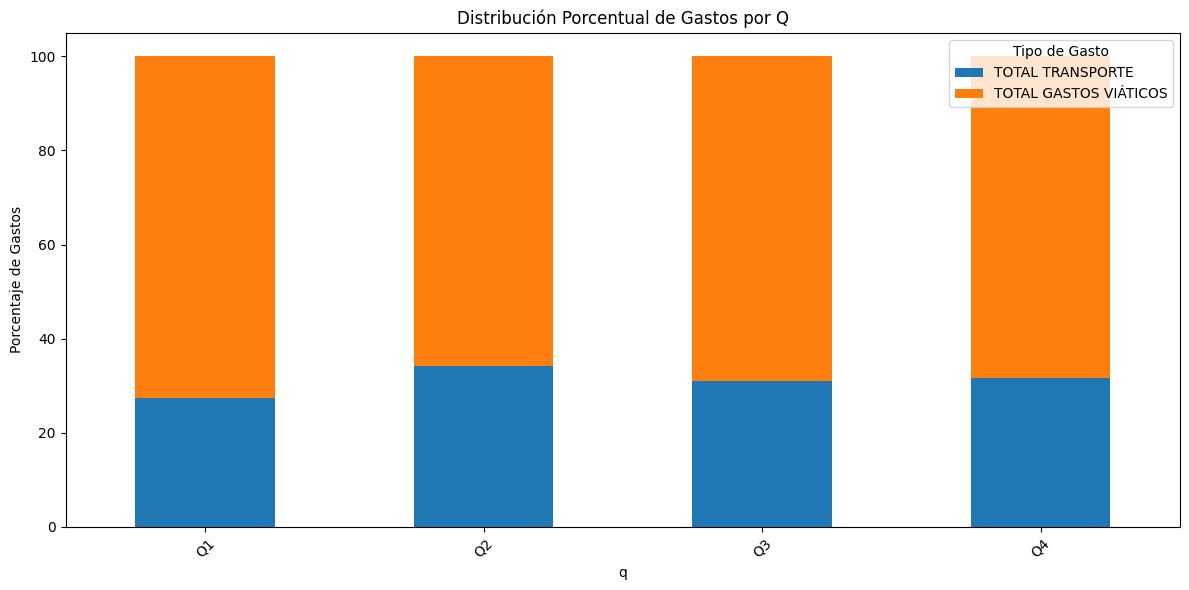

In [31]:
# Agrupar por 'q' y sumar los gastos
gastos_agrupados = datos.groupby('Q')[['TOTAL TRANSPORTE', 'TOTAL GASTOS VIÁTICOS']].sum()

# Calcular los porcentajes
gastos_porcentuales = gastos_agrupados.div(gastos_agrupados.sum(axis=1), axis=0) * 100

# Crear el gráfico de barras porcentuales apiladas
gastos_porcentuales.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Distribución Porcentual de Gastos por Q')
plt.xlabel('q')
plt.ylabel('Porcentaje de Gastos')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Gasto')
plt.tight_layout()
plt.show()

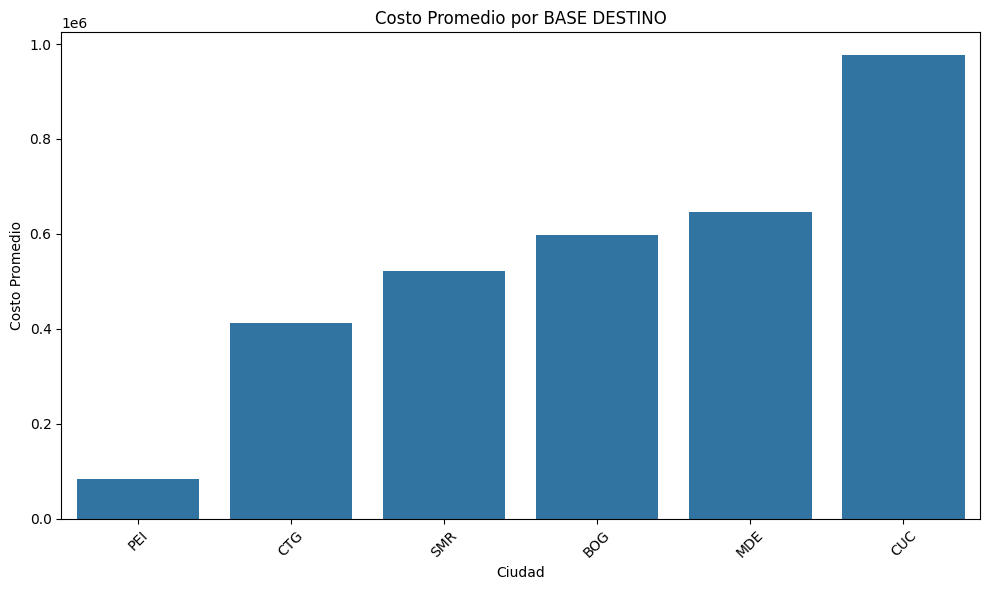

In [32]:
# Calcular el costo promedio por ciudad
costo_promedio_ciudad = datos.groupby('BASE DESTINO')['TOTAL GASTOS'].mean().sort_values()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=costo_promedio_ciudad.index, y=costo_promedio_ciudad.values)
plt.title('Costo Promedio por BASE DESTINO')
plt.xlabel('Ciudad')
plt.ylabel('Costo Promedio')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

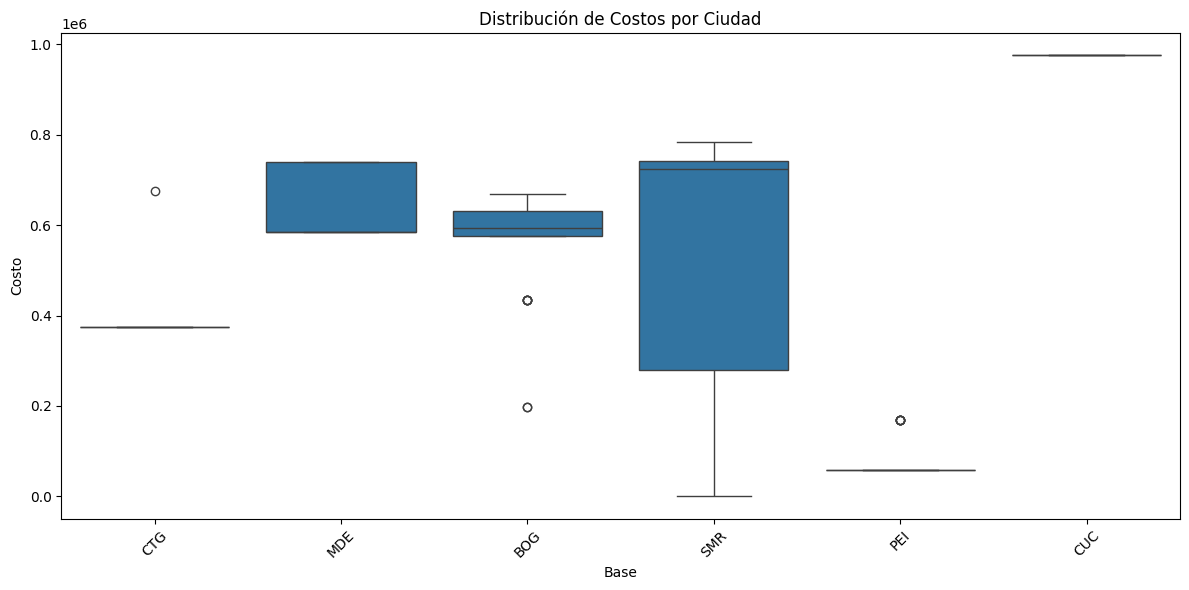

In [33]:
# Crear el diagrama de cajas
plt.figure(figsize=(12, 6))
sns.boxplot(x='BASE DESTINO', y='TOTAL GASTOS', data=datos)
plt.title('Distribución de Costos por Ciudad')
plt.xlabel('Base')
plt.ylabel('Costo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

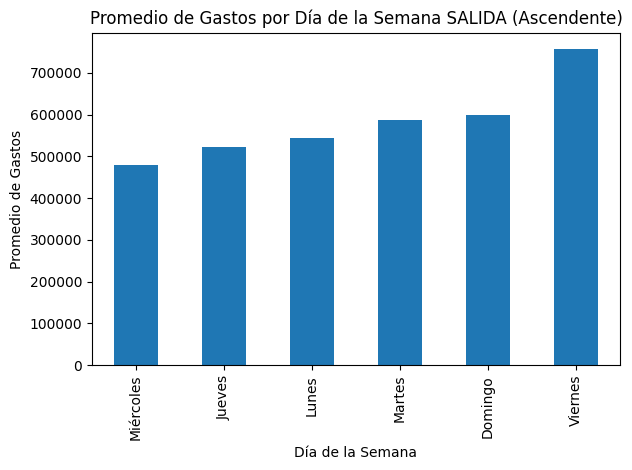

In [34]:

promedio_gastos_por_dia = datos.groupby('DÍA DE LA SEMANA DE SALIDA')['TOTAL GASTOS'].mean()

promedio_gastos_por_dia_ordenado = promedio_gastos_por_dia.sort_values()

dias_semana = {
    0: 'Lunes',
    1: 'Martes',
    2: 'Miércoles',
    3: 'Jueves',
    4: 'Viernes',
    5: 'Sábado',
    6: 'Domingo'
}

promedio_gastos_por_dia_ordenado.index = promedio_gastos_por_dia_ordenado.index.map(dias_semana)

promedio_gastos_por_dia_ordenado.plot(kind='bar')

plt.title('Promedio de Gastos por Día de la Semana SALIDA (Ascendente)')
plt.xlabel('Día de la Semana')
plt.ylabel('Promedio de Gastos')
plt.tight_layout()
plt.show()

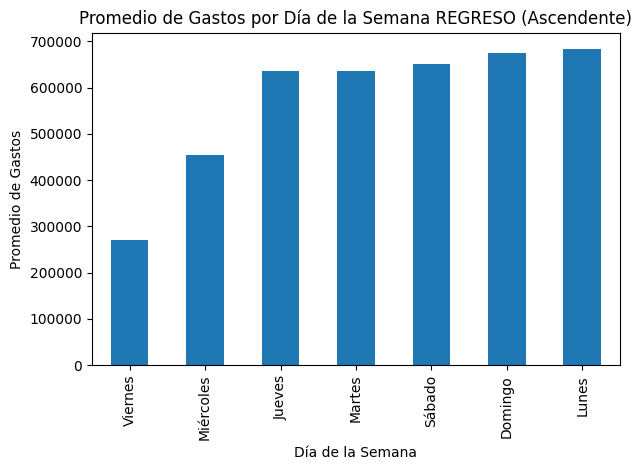

In [35]:
promedio_gastos_por_dia = datos.groupby('DÍA DE LA SEMANA DE REGRESO')['TOTAL GASTOS'].mean()

promedio_gastos_por_dia_ordenado = promedio_gastos_por_dia.sort_values()

dias_semana = {
    0: 'Lunes',
    1: 'Martes',
    2: 'Miércoles',
    3: 'Jueves',
    4: 'Viernes',
    5: 'Sábado',
    6: 'Domingo'
}

promedio_gastos_por_dia_ordenado.index = promedio_gastos_por_dia_ordenado.index.map(dias_semana)

promedio_gastos_por_dia_ordenado.plot(kind='bar')

plt.title('Promedio de Gastos por Día de la Semana REGRESO (Ascendente)')
plt.xlabel('Día de la Semana')
plt.ylabel('Promedio de Gastos')
plt.tight_layout()
plt.show()

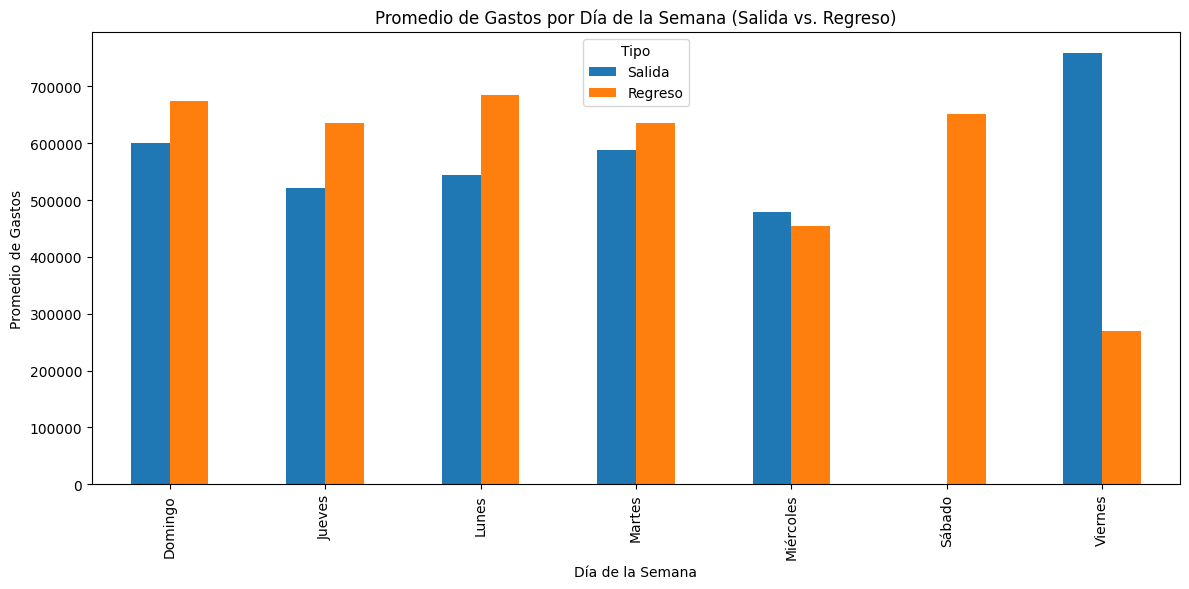

In [36]:
promedio_salida = datos.groupby('DÍA DE LA SEMANA DE SALIDA')['TOTAL GASTOS'].mean()
promedio_regreso = datos.groupby('DÍA DE LA SEMANA DE REGRESO')['TOTAL GASTOS'].mean()

dias_semana = {
    0: 'Lunes',
    1: 'Martes',
    2: 'Miércoles',
    3: 'Jueves',
    4: 'Viernes',
    5: 'Sábado',
    6: 'Domingo'
}

promedio_salida.index = promedio_salida.index.map(dias_semana)
promedio_regreso.index = promedio_regreso.index.map(dias_semana)

df_grafico = pd.DataFrame({'Salida': promedio_salida, 'Regreso': promedio_regreso})

df_grafico.plot(kind='bar', figsize=(12, 6))

plt.title('Promedio de Gastos por Día de la Semana (Salida vs. Regreso)')
plt.xlabel('Día de la Semana')
plt.ylabel('Promedio de Gastos')
plt.legend(title='Tipo')
plt.tight_layout()
plt.show()

In [37]:
tabla_conteo = pd.crosstab(datos['DÍA DE LA SEMANA DE SALIDA'], datos['DÍA DE LA SEMANA DE REGRESO'])

dias_semana = {
    0: 'Lunes',
    1: 'Martes',
    2: 'Miércoles',
    3: 'Jueves',
    4: 'Viernes',
    5: 'Sábado',
    6: 'Domingo'
}

tabla_conteo.index = tabla_conteo.index.map(dias_semana)
tabla_conteo.columns = tabla_conteo.columns.map(dias_semana)

print(tabla_conteo)

DÍA DE LA SEMANA DE REGRESO  Lunes  Martes  Miércoles  Jueves  Viernes  Sábado  Domingo
DÍA DE LA SEMANA DE SALIDA                                                             
Lunes                            6       2          0       0        0      16        0
Martes                          26       8         15      84        0       0        0
Miércoles                        0       0        107       0        0       0        0
Jueves                           8       0          0      48       10       0        0
Viernes                          0       0          0      29        6       0        1
Domingo                          0       0          5      11        7       0        0


<Axes: >

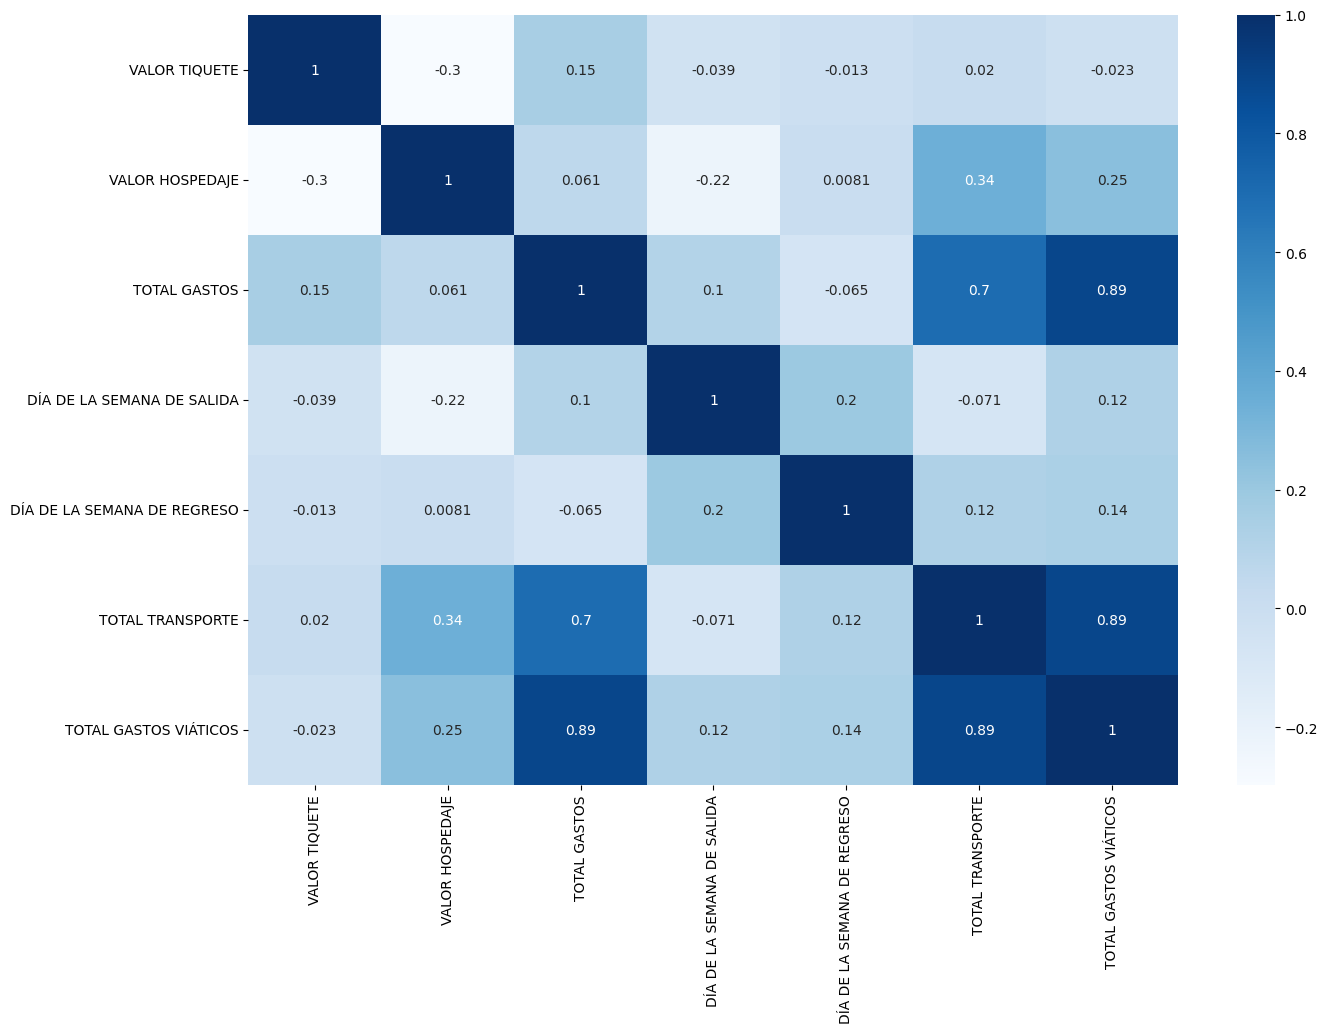

In [38]:
plt.figure(figsize = (15,10))
sns.heatmap(datos.corr(numeric_only = True), cmap = 'Blues', annot = True)

Genero un gráfico de calor en el que puedo ver correlaciones entre las variables del dataframe. 

En este caso "TOTAL GASTOS VIÁTICOS" tiene correlación superior al 85% con la variable objetivo, por lo tanto procedo a eliminar


In [39]:
datos.corr(numeric_only = True)

,VALOR TIQUETE,VALOR HOSPEDAJE,TOTAL GASTOS,DÍA DE LA SEMANA DE SALIDA,DÍA DE LA SEMANA DE REGRESO,TOTAL TRANSPORTE,TOTAL GASTOS VIÁTICOS
VALOR TIQUETE,1.000000,-0.296480,0.153044,-0.039137,-0.012754,0.020478,-0.022783
VALOR HOSPEDAJE,-0.296480,1.000000,0.060991,-0.221404,0.008072,0.344358,0.254353
TOTAL GASTOS,0.153044,0.060991,1.000000,0.104143,-0.065319,0.700948,0.891548
DÍA DE LA SEMANA DE SALIDA,-0.039137,-0.221404,0.104143,1.000000,0.199096,-0.070938,0.121737
DÍA DE LA SEMANA DE REGRESO,-0.012754,0.008072,-0.065319,0.199096,1.000000,0.123035,0.137927
TOTAL TRANSPORTE,0.020478,0.344358,0.700948,-0.070938,0.123035,1.000000,0.892078
TOTAL GASTOS VIÁTICOS,-0.022783,0.254353,0.891548,0.121737,0.137927,0.892078,1.000000


In [40]:
corr_matrix = datos.corr(numeric_only = True).abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
drop_corr = [col for col in upper.columns if any(upper[col]>0.85)]

In [41]:
drop_corr

['TOTAL GASTOS VIÁTICOS']

In [42]:
datos = datos.drop(drop_corr, axis=1)

In [43]:
datos = datos.drop('Q', axis=1)

In [44]:
datos.dtypes # visualizamos los tipos

Ejercicio                        object
Periodo                          object
BASE ORIGEN                      object
BASE DESTINO                     object
SOLICITUD TIQUETES               object
SOLICITUD HOSPEDAJE              object
VALOR TIQUETE                   float64
VALOR HOSPEDAJE                 float64
TOTAL GASTOS                    float64
servicio                         object
grado_cargo                      object
DURACIÓN DEL VIAJE (FORMATO)     object
DÍA DE LA SEMANA DE SALIDA        int32
DÍA DE LA SEMANA DE REGRESO       int32
TOTAL TRANSPORTE                float64
HOSPEDAJE FAMILIAR AMIGO         object
dtype: object

In [45]:
y = datos["TOTAL GASTOS"]
X = datos.drop(columns=["TOTAL GASTOS"])

# Ajuste y evaluación de distintos modelos de regresión

### División en train y test

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Conversión de categóricas a numéricas y escalado

Las variables categóricas no siguen un orden o jerarquía, las transformamos a dummies con OneHotEncoder. Las variables numéricas las escalamos. Para hacer ambas transformaciones de una sola vez y poder guardarlas en un fichero .pkl para la posterior productivización, es conveniente utilizar un Pipeline:

In [47]:
# Obtenemos lista con los nombres de las columnas categóricas y numéricas por separado

cat_cols = X.select_dtypes(include = ['object']).columns
num_cols = X.select_dtypes(include = ['integer', 'float']).columns

In [48]:
# Definir transformadores para columnas categóricas y numéricas

transformadores = [
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop = "first"), 
     cat_cols),  # OneHotEncoder para las columnas categoricas
    ('scaler', StandardScaler(), num_cols)]  # StandardScaler para las columnas numéricas

# ColumnTransformer facilita aplicar diferentes transformaciones segun la columna
preprocesador = ColumnTransformer(transformadores)

# Crear el pipeline completo con OneHotEncoder seguido de StandardScaler
pipeline = Pipeline(steps=[('preprocesador', preprocesador)])

In [49]:
# Ajustar el pipeline sobre el conjunto de datos de train y transformar los datos de train y test

X_train = pipeline.fit_transform(X_train) # el objeto "pipeline" se puede guardar en formato pkl
X_test = pipeline.transform(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1, 2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Random Forest
---

In [50]:
params = {"max_depth": range(2, 10),
          "min_samples_leaf": range(10, 60),
          "max_features": [0.3, 0.5, 0.7, 0.9]}

rf = RandomForestRegressor()

rf_cv = RandomizedSearchCV(rf, params, cv=3, n_iter = 10)

rf_cv.fit(X_train, y_train)

rf_cv.best_params_

{'min_samples_leaf': 17, 'max_features': 0.5, 'max_depth': 3}

In [51]:
rf = RandomForestRegressor(**rf_cv.best_params_)
rf.fit(X_train, y_train)
predict_and_get_r2(rf)

La R^2 en los datos de train es: 0.73
La R^2 en los datos de test es: 0.72


In [52]:
params = {"max_depth": [6, 7, 8],
          "min_samples_leaf": [12, 14, 16],
          "max_features": [0.5, 0.6, 0.7]}

rf_cv = GridSearchCV(rf, params, cv=5)

rf_cv.fit(X_train, y_train)

rf_cv.best_params_

{'max_depth': 8, 'max_features': 0.6, 'min_samples_leaf': 12}

In [53]:
rf = RandomForestRegressor(**rf_cv.best_params_)
rf.fit(X_train, y_train)
predict_and_get_r2(rf)

La R^2 en los datos de train es: 0.8
La R^2 en los datos de test es: 0.79


## 2. XGBoost
---

In [54]:
params = {"max_depth": [2, 3],  # Reducción agresiva
    "eta": [0.001, 0.005, 0.01],  # Reducción agresiva
    "subsample": [0.5, 0.6],  # Reducción agresiva
    "colsample_bytree": [0.5, 0.6],  # Reducción agresiva
    "n_estimators": [300, 500, 700], # aumento de estimadores.
    "reg_alpha": [1, 5, 10],  # Regularización L1 agresiva
    "reg_lambda": [1, 5, 10],  # Regularización L2 agresiva
    "gamma": [0.5, 1, 2], # Regularizacion agresiva.
    "min_child_weight": [3, 5, 7] # regularización agresiva
    }

xgb = XGBRegressor(early_stopping_rounds=10, eval_metric="rmse")

xgb_cv = RandomizedSearchCV(xgb, params, cv=5, n_iter=10)
 
xgb_cv.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False) 

xgb_cv.best_params_

{'subsample': 0.6,
 'reg_lambda': 1,
 'reg_alpha': 10,
 'n_estimators': 700,
 'min_child_weight': 7,
 'max_depth': 3,
 'gamma': 2,
 'eta': 0.005,
 'colsample_bytree': 0.5}

In [56]:
xgb = XGBRegressor(**xgb_cv.best_params_) 
xgb.fit(X_train, y_train)
predict_and_get_r2(xgb)

La R^2 en los datos de train es: 0.92
La R^2 en los datos de test es: 0.91


In [57]:
params = {
    'subsample': [0.5, 0.55],
    'reg_lambda': [1, 1.2],
    'reg_alpha': [1, 1.2],
    'n_estimators': [300, 400], 
    'min_child_weight': [3, 4],
    'max_depth': [2],
    'gamma': [2], 
    'eta': [0.005, 0.006],
    'colsample_bytree': [0.5, 0.55]
}

xgb = XGBRegressor(early_stopping_rounds=10, eval_metric="rmse")

xgb_grid = GridSearchCV(xgb, params, cv=3)

xgb_grid.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=10,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.5, 0.55], 'eta': [0.005, 0.006],
                         'gamma': [2], 'max_depth': [2],
                         'min_child_weight': [3, 4], 'n_estimators': [300, 400],
                         'reg_alpha': [1, 1.2], 'reg_lambda': [1, 1.2],
                         'subsample': [0.5, 0.55]})

In [58]:
xgb = XGBRegressor(**xgb_cv.best_params_) 
xgb.fit(X_train, y_train)
predict_and_get_r2(xgb)

La R^2 en los datos de train es: 0.92
La R^2 en los datos de test es: 0.91


In [68]:
nombre_archivo_pkl = 'modelo_xgboost.pkl'  # Elige el nombre que quieras para tu archivo
ruta_guardado = '/Users/christian/Downloads'  # Reemplaza con la ruta deseada

import os
ruta_completa = os.path.join(ruta_guardado, nombre_archivo_pkl)

try:
    with open(ruta_completa, 'wb') as archivo:
        pickle.dump(xgb, archivo)
    print(f"El modelo XGBoost se ha guardado exitosamente en: '{ruta_completa}'")
except Exception as e:
    print(f"Ocurrió un error al guardar el modelo: {e}")

El modelo XGBoost se ha guardado exitosamente en: '/Users/christian/Downloads/modelo_xgboost.pkl'


**De los 2 algoritmos ajustados el que mejor funciona es el XGBoost, pues consigue un R cuadrado más alto en test**

## Evaluación del modelo final
---

In [60]:
y_pred = xgb.predict(X_test)

In [61]:
print("MSE = ", str(round(mean_squared_error(y_test, y_pred), 2)))
print("RMSE = ", str(round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)))
print("MAE = ", str(round(mean_absolute_error(y_test, y_pred), 2))) # si no se quiere penalizar tanto predicciones que se desvían mucho

MSE =  5058527267.94
RMSE =  71123.32
MAE =  38660.65


- ### Importancia de variables

In [62]:
imp_datos = pd.DataFrame({"variable": pipeline.get_feature_names_out(), "importancia relativa": xgb.feature_importances_}) \
.sort_values(by='importancia relativa', ascending = False)

In [63]:
imp_datos.head()

,variable,importancia relativa
45,scaler__TOTAL TRANSPORTE,0.112781
7,onehot__BASE ORIGEN_AXM,0.097001
18,onehot__BASE DESTINO_PEI,0.090075
25,onehot__grado_cargo_AUXILIAR DE SERVICIOS I,0.061511
39,onehot__DURACIÓN DEL VIAJE (FORMATO)_6 días,0.059756


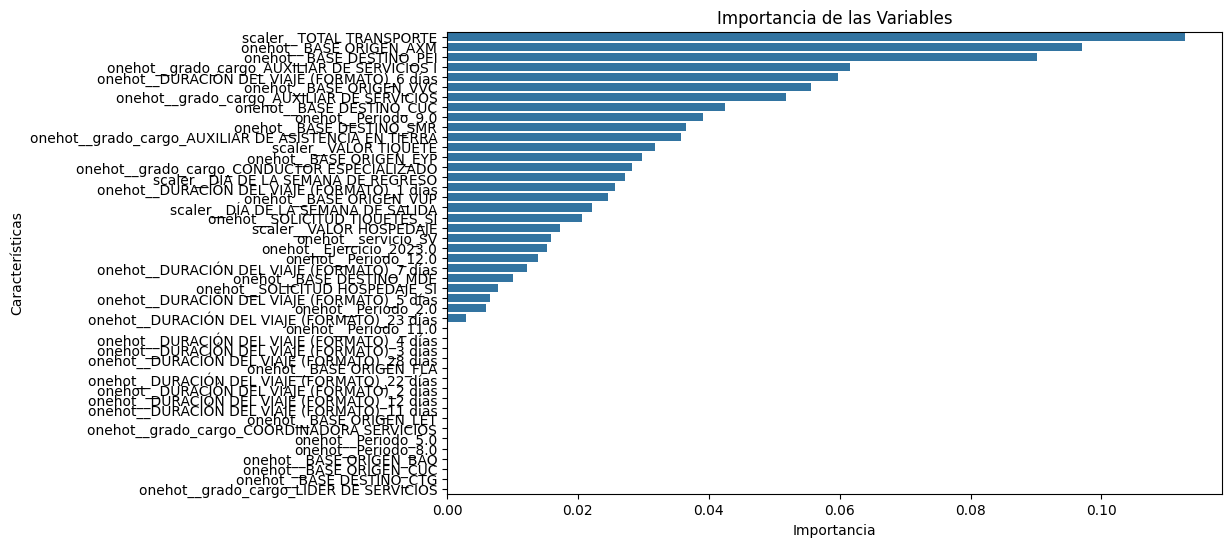

In [64]:
plt.figure(figsize=(10, 6))
sns.barplot(data=imp_datos, x='importancia relativa', y='variable')
plt.title('Importancia de las Variables')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

In [65]:

# Convertir X_test de matriz dispersa a un array denso y luego a DataFrame
# Si X_test es una matriz dispersa (como csr_matrix)
X_test_dense = X_test.toarray() if hasattr(X_test, 'toarray') else X_test
datos_test = pd.DataFrame(X_test_dense, columns=pipeline.get_feature_names_out())
datos_test['valor_real'] = y_test
datos_test['valor_predicho'] = y_pred

# Ordenamos las observaciones
datos_test_sorted = datos_test.sort_values(by='valor_real').reset_index(drop=True)

In [66]:
datos_test_sorted.head()

,onehot__Ejercicio_2023.0,onehot__Periodo_11.0,onehot__Periodo_12.0,onehot__Periodo_2.0,onehot__Periodo_5.0,onehot__Periodo_8.0,onehot__Periodo_9.0,onehot__BASE ORIGEN_AXM,onehot__BASE ORIGEN_BAQ,onehot__BASE ORIGEN_CUC,onehot__BASE ORIGEN_EYP,onehot__BASE ORIGEN_FLA,onehot__BASE ORIGEN_LET,onehot__BASE ORIGEN_VUP,onehot__BASE ORIGEN_VVC,onehot__BASE DESTINO_CTG,onehot__BASE DESTINO_CUC,onehot__BASE DESTINO_MDE,onehot__BASE DESTINO_PEI,onehot__BASE DESTINO_SMR,onehot__SOLICITUD TIQUETES_SI,onehot__SOLICITUD HOSPEDAJE_SI,onehot__servicio_SV,onehot__grado_cargo_AUXILIAR DE ASISTENCIA EN TIERRA,onehot__grado_cargo_AUXILIAR DE SERVICIOS,onehot__grado_cargo_AUXILIAR DE SERVICIOS I,onehot__grado_cargo_CONDUCTOR ESPECIALIZADO,onehot__grado_cargo_COORDINADORA SERVICIOS,onehot__grado_cargo_LIDER DE SERVICIOS,onehot__DURACIÓN DEL VIAJE (FORMATO)_1 días,onehot__DURACIÓN DEL VIAJE (FORMATO)_11 días,onehot__DURACIÓN DEL VIAJE (FORMATO)_12 días,onehot__DURACIÓN DEL VIAJE (FORMATO)_2 días,onehot__DURACIÓN DEL VIAJE (FORMATO)_22 días,onehot__DURACIÓN DEL VIAJE (FORMATO)_23 días,onehot__DURACIÓN DEL VIAJE (FORMATO)_28 días,onehot__DURACIÓN DEL VIAJE (FORMATO)_3 días,onehot__DURACIÓN DEL VIAJE (FORMATO)_4 días,onehot__DURACIÓN DEL VIAJE (FORMATO)_5 días,onehot__DURACIÓN DEL VIAJE (FORMATO)_6 días,onehot__DURACIÓN DEL VIAJE (FORMATO)_7 días,scaler__VALOR TIQUETE,scaler__VALOR HOSPEDAJE,scaler__DÍA DE LA SEMANA DE SALIDA,scaler__DÍA DE LA SEMANA DE REGRESO,scaler__TOTAL TRANSPORTE,valor_real,valor_predicho
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.004700,-0.130080,0.671692,0.475375,0.126896,175000.0,593026.93750
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.004700,1.470219,-0.784087,0.475375,0.571070,175000.0,622801.00000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-2.381208,1.032093,-0.784087,-1.283835,0.079240,175000.0,671167.50000
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.004700,-2.472912,-0.784087,-0.404230,-2.073109,175000.0,315099.84375
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.004700,-0.130080,-1.511977,-2.163440,-2.403631,175000.0,377706.00000


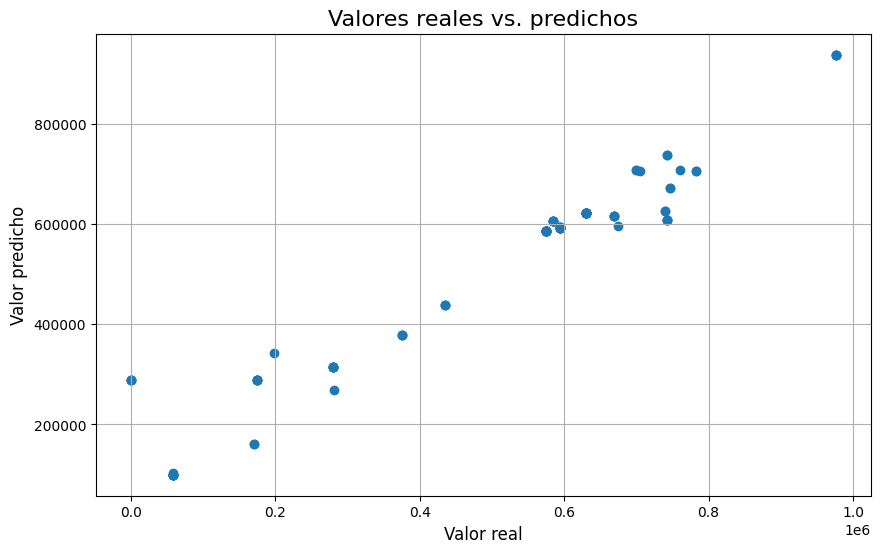

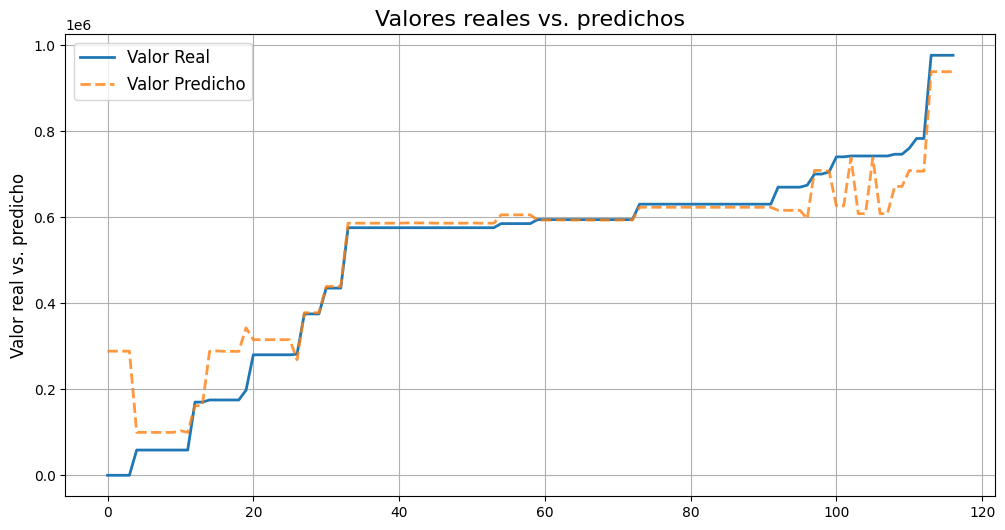

In [67]:
# Crear DataFrame con valores reales y predicciones
datos_test = pd.DataFrame({
    'valor_real': y_test,
    'valor_predicho': y_pred
})

# Ordenar para visualización
datos_test_sorted = datos_test.sort_values(by='valor_real').reset_index(drop=True)

# Gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(datos_test['valor_real'], datos_test['valor_predicho'])
plt.title("Valores reales vs. predichos", fontsize=16)
plt.xlabel("Valor real", fontsize=12)
plt.ylabel("Valor predicho", fontsize=12)
plt.grid(True)
plt.show()

# Gráfico de líneas
plt.figure(figsize=(12, 6))
plt.plot(datos_test_sorted['valor_real'], label='Valor Real', linewidth=2)
plt.plot(datos_test_sorted['valor_predicho'], label='Valor Predicho', linestyle='--', linewidth=2, alpha=0.8)
plt.title("Valores reales vs. predichos", fontsize=16)
plt.ylabel("Valor real vs. predicho", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()